In [1]:
import numpy as np
import pandas as pd
import os
import torch

In [2]:
csv_list = os.listdir("train")

df = pd.DataFrame()

for file in csv_list:
    if file.endswith(".csv"):
        df_temp = pd.read_csv(f"train/{file}")
        df = pd.concat([df, df_temp])
        df["Sunlight_overflow"] = df['Sunlight(Lux)'].apply(lambda x: 1 if x == 117758.2 else 0)
df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Sunlight_overflow
0,10,2024-03-01 17:14:06.000,0.0,1017.48,15.59,94.30,652.92,0.12,0
1,10,2024-03-01 17:14:47.000,0.0,1017.48,15.66,94.04,682.50,0.12,0
2,10,2024-03-01 17:15:47.000,0.0,1017.47,15.74,94.10,750.00,0.14,0
3,10,2024-03-01 17:16:47.000,0.0,1017.46,15.78,94.09,738.33,0.14,0
4,10,2024-03-01 17:17:47.000,0.0,1017.49,15.80,94.08,660.83,0.12,0
...,...,...,...,...,...,...,...,...,...
89607,9,2024-07-23 15:50:57.000,0.0,994.54,30.69,72.91,2288.33,1.10,0
89608,9,2024-07-23 15:51:57.000,0.0,994.40,30.27,73.16,3236.67,1.92,0
89609,9,2024-07-23 15:52:57.000,0.0,994.39,29.90,72.51,4526.67,3.57,0
89610,9,2024-07-23 15:53:57.000,0.0,994.40,29.38,73.23,4231.67,3.13,0


In [3]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

encoder = ce.LeaveOneOutEncoder(cols=["LocationCode"], sigma = 0.05)
encoder.fit(df, df['Power(mW)'])
df = encoder.transform(df)

# 指定要標準化的欄位
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'LocationCode']

# 初始化 StandardScaler
scaler = StandardScaler()

# 對指定欄位進行標準化
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])



df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Sunlight_overflow
0,-0.754370,2024-03-01 17:14:06.000,-0.420823,0.487473,-1.661978,1.003364,-0.714856,0.12,0
1,-0.754370,2024-03-01 17:14:47.000,-0.420823,0.487473,-1.654168,0.992914,-0.713834,0.12,0
2,-0.754370,2024-03-01 17:15:47.000,-0.420823,0.486877,-1.645242,0.995326,-0.711501,0.14,0
3,-0.754370,2024-03-01 17:16:47.000,-0.420823,0.486282,-1.640779,0.994924,-0.711904,0.14,0
4,-0.754370,2024-03-01 17:17:47.000,-0.420823,0.488069,-1.638547,0.994522,-0.714583,0.12,0
...,...,...,...,...,...,...,...,...,...
89607,-1.254433,2024-07-23 15:50:57.000,-0.420823,-0.879118,0.022800,0.143706,-0.658330,1.10,0
89608,-1.254433,2024-07-23 15:51:57.000,-0.420823,-0.887458,-0.024061,0.153753,-0.625551,1.92,0
89609,-1.254433,2024-07-23 15:52:57.000,-0.420823,-0.888054,-0.065344,0.127630,-0.580963,3.57,0
89610,-1.254433,2024-07-23 15:53:57.000,-0.420823,-0.887458,-0.123362,0.156566,-0.591160,3.13,0


In [4]:
def spilt_data_with_datetime(df: pd.DataFrame):
    op_df = list(pd.to_datetime(df['DateTime']).dt.day)
    
    data_df = df.drop(columns=['DateTime', 'Power(mW)'])
    label_df = df['Power(mW)']

    data_list = []
    label_list = []
    last_index = 0
    for i in range(1, len(op_df) - 1):
        if op_df[i] != op_df[i - 1]:
            data_list.append(torch.from_numpy(np.array(data_df.iloc[last_index: i])))
            label_list.append(torch.from_numpy(np.array(label_df.iloc[last_index:i])))
            last_index = i
    return data_list, label_list

In [5]:
data_list, label_list = spilt_data_with_datetime(df)

data_list[0].shape, label_list[0].shape

(torch.Size([52, 7]), torch.Size([52]))

In [6]:
num_samples = len(data_list)

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt


In [8]:
# 計算各個數據集的大小
train_size = int(num_samples * 0.9)
valid_size = int(num_samples * 0.05)
test_size = num_samples - train_size - valid_size

# 分割數據
train_data = data_list[:train_size]
train_labels = label_list[:train_size]

valid_data = data_list[train_size:train_size + valid_size]
valid_labels = label_list[train_size:train_size + valid_size]

test_data = data_list[train_size + valid_size:]
test_labels = label_list[train_size + valid_size:]


In [9]:
class SequenceDataset(Dataset):
    def __init__(self, data_list, label_list):
        self.data_list = data_list
        self.label_list = label_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx], self.label_list[idx]


In [10]:
def collate_fn(batch):
    # 取得每個樣本的數據和標籤
    data_batch = [item[0] for item in batch]
    label_batch = [item[1] for item in batch]

    # 取得每個序列的長度
    data_lengths = torch.Tensor([len(seq) for seq in data_batch])

    # 進行padding
    data_padded = pad_sequence(data_batch, batch_first=True, padding_value=0)
    label_padded = pad_sequence(label_batch, batch_first=True, padding_value=0)

    return data_padded, label_padded, data_lengths


In [11]:
batch_size = 64

# 訓練集
train_dataset = SequenceDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# 驗證集
valid_dataset = SequenceDataset(valid_data, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 測試集
test_dataset = SequenceDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [12]:
class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, num_layers=2, output_size=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        # 將序列進行打包
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # 通過LSTM層
        packed_output, (hn, cn) = self.lstm(packed_input)
        # 解包序列
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # 通過全連接層
        output = self.fc(output)
        return output


In [13]:
def evaluate(model, device, data_loader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, labels, lengths in data_loader:
            data = data.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            outputs = model(data, lengths).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(data_loader.dataset) / lengths.sum()
    return avg_loss


In [14]:
def train(model, device, train_loader, valid_loader, criterion, optimizer, num_epochs):
    model.to(device)
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, labels, lengths in train_loader:
            data = data.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            
            optimizer.zero_grad()

            outputs = model(data, lengths).squeeze()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset) / lengths.sum()
        train_losses.append(epoch_train_loss)

        # 使用evaluate計算驗證損失
        epoch_valid_loss = evaluate(model, device, valid_loader, criterion)
        valid_losses.append(epoch_valid_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

    # 繪製損失曲線
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch [1/50], Train Loss: 10490.8652, Valid Loss: 657.6558
Epoch [2/50], Train Loss: 10652.8252, Valid Loss: 654.2750
Epoch [3/50], Train Loss: 9842.4570, Valid Loss: 651.9775
Epoch [4/50], Train Loss: 10564.4043, Valid Loss: 649.8519
Epoch [5/50], Train Loss: 9933.5576, Valid Loss: 647.8428
Epoch [6/50], Train Loss: 9802.7539, Valid Loss: 645.9727
Epoch [7/50], Train Loss: 11018.4346, Valid Loss: 644.1299
Epoch [8/50], Train Loss: 9799.9873, Valid Loss: 642.3315
Epoch [9/50], Train Loss: 9857.2275, Valid Loss: 640.5374
Epoch [10/50], Train Loss: 10247.3867, Valid Loss: 638.8504
Epoch [11/50], Train Loss: 9790.1104, Valid Loss: 637.1206
Epoch [12/50], Train Loss: 9284.1602, Valid Loss: 635.4179
Epoch [13/50], Train Loss: 9689.0176, Valid Loss: 633.8586
Epoch [14/50], Train Loss: 9239.2998, Valid Loss: 632.2777
Epoch [15/50], Train Loss: 10601.5566, Valid Loss: 630.5673
Epoch [16/50], Train Loss: 10293.8008, Valid Loss: 629.0108
Epoch [17/50], Train Loss: 9973.9023, Valid Loss: 627.5095

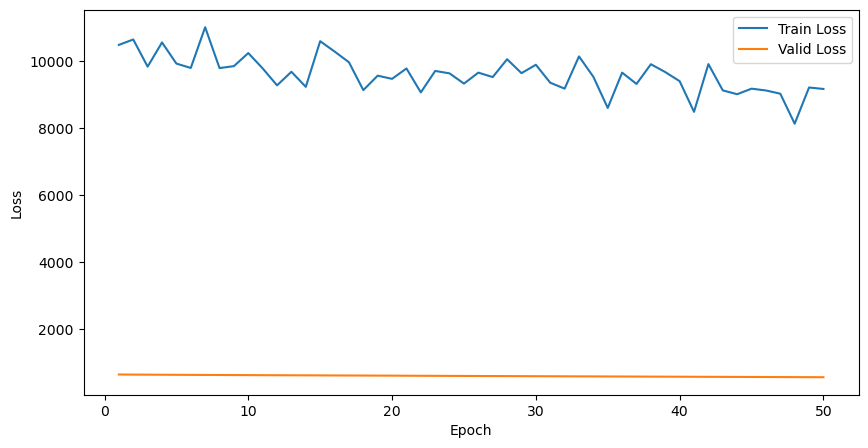

In [15]:
# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義模型、損失函數和優化器
model = RNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 50
train(model, device, train_loader, valid_loader, criterion, optimizer, num_epochs)




In [16]:
# 測試模型並顯示損失
test_loss = evaluate(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 314.0001


In [17]:
#show
model = model.to(device='cpu')
model.eval()
show_data = torch.tensor(data_list[0]).unsqueeze(dim=0)
show_data = show_data.to(device='cpu', dtype=torch.float32)
length = [52]
outputs = model(show_data, length).squeeze()
show_data.shape

C:\Users\weiso131\AppData\Local\Temp\ipykernel_24664\657085121.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show_data = torch.tensor(data_list[0]).unsqueeze(dim=0)


torch.Size([1, 52, 7])

In [18]:
outputs

tensor([-3.3262e+00, -3.6208e+00, -3.2606e+00, -2.6651e+00, -1.9957e+00,
        -1.3612e+00, -9.1223e-01, -5.1449e-01, -2.3972e-01, -6.7486e-02,
         2.8484e-02,  8.6520e-02,  8.4538e-03, -2.8615e-03,  2.9238e-02,
         4.1722e-02,  9.2631e-02,  1.0604e-01,  7.3386e-02,  1.7709e-02,
        -7.0948e-02, -8.1705e-02, -8.8568e-02, -1.1146e-01, -1.3041e-01,
        -1.4781e-01, -1.5721e-01, -1.5113e-01, -1.6497e-01, -1.5255e-01,
        -1.4625e-01, -1.5316e-01, -1.6863e-01, -1.8766e-01, -2.4958e-01,
        -3.2235e-01, -3.2119e-01, -2.1112e-01, -1.6522e-01, -1.8545e-01,
        -2.2565e-01, -2.5622e-01, -2.6896e-01, -2.7157e-01, -2.7159e-01,
        -2.9017e-01, -2.7640e-01, -2.7051e-01, -2.7454e-01, -2.7839e-01,
        -2.8399e-01, -2.8641e-01], grad_fn=<SqueezeBackward0>)

In [19]:
label_list[0]

tensor([0.1200, 0.1200, 0.1400, 0.1400, 0.1200, 0.1000, 0.0700, 0.0600, 0.0700,
        0.0600, 0.0700, 0.0700, 0.0700, 0.0600, 0.0600, 0.0600, 0.0500, 0.0300,
        0.0300, 0.0300, 0.0300, 0.0200, 0.0200, 0.0200, 0.0100, 0.0100, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0100, 0.0200, 0.0100, 0.0100, 0.0100, 0.0000,
        0.0100, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)